<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/jvcqp2iy2jlx2b32rmzdt0tx8lvxgzkp.png" width = 300, align = "center"></a>

<h1 align=center><font size = 5> MUSIC GENRE CLASSIFICATION USING TENSORFLOW - PART 1</font></h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size = 3><strong>In this notebook we provide a brief overview of the music project, explain the data set, and help you extract features from the raw data</strong></font>
<br>
- <p><a href="#ref2">Overview of the project</a></p>
- <p><a href="#ref3">Brief explanation of the data set</a></p>
- <p><a href="#ref4">Feature extraction</a></p>
<p></p>
</div>
<br>

----------------

<a id="ref2"></a>
# Overview of the project

In this project, our objective is to classify a sample of music into a specific genre using convolutional networks. Similar to the way images of handwritten numbers are classified into any one of 10 digit classes in the MNIST data set, here we take samples/excerpts of music and classify these excerpts into any one of 9 genres - Alternative, Blues, Electronic, Folk/Country, Funk/Soul/R&B, Jazz, Pop, Rap/Hiphop, Rock.

The project is broken into two modules. In this first of two modules, we will download the data set, understand how the data set is structured, and extract relevant features. These features will be used later in the second module to train convolutional networks for the purpose of genre classification. 

<a id="ref3"></a>
# Brief explanation of the data set

We will use the [Music Audio Benchmark Data Set](http://www-ai.cs.uni-dortmund.de/audio.html) for this project, created by [Homburg et al. (2005)](http://www-ai.cs.uni-dortmund.de/audio.html) and [Mierswa et al. (2005)](http://www-ai.cs.uni-dortmund.de/audio.html). The data set contains 1886 song excerpts, from 9 genres (listed above), encoded in mp3 format. The frequency and bitrate of these files are 44,100 Hz and 128 kb respectively. Each excerpt is 10 seconds in duration. For ease of use, the data has already been imported and split for training the networks and testing how the networks perform. The train:test data split is approximately 80:20, respectively.

In the next section, we will extract the necessary features for genre classification.

<a id="ref4"></a>
# Feature extraction

In a computer vision problem such as handwritten digit recognition using MNIST, we can use features such as pixel values or RGB values. Audio signals, particularly music excerpts, are temporal and more complex. As such, they offer a rich variety of features ranging from low-level acoustic to high-level musical features. Low-level features could be spectral and spectrotemporal features while high-level features could be tempo, rhythm, key, pitch, and harmonic information. Since deep learning is primarily designed for feature learning, it makes sense to use lower level features in this project. So, we will use mel frequency cepstral coefficients (MFCCs) as our features.

MFCCs are supposed to mimic the logarithmic perception of loudness and pitch of the human auditory system. Although MFCCs have been used mostly in speech recognition, they have become very popular as features for problems within the music information retrieval community. For a deeper understanding of MFCCs, we highly recommend going through the following sources: 1) [This excellent video](https://archive.org/details/SpectrogramCepstrumAndMel-frequency_636522) by Kishore Prahallad, and 2) this short [explanatory tutorial](http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

We will use [Librosa](http://librosa.github.io/librosa/), a python package for music and audio analysis, for extracting MFCC features from music.

In [ ]:
# Put this before all imports for the librosa package    
!pip install librosa

In [ ]:
# Get the links for all the Music Training data (part1) and Music Testing data (part2) 
!wget -q -c --progress=bar:force https://ibm.box.com/shared/static/zv4o44z5wzpyqgjvq07ed00dqlpb7mho.gz -O part1.tar.gz
!wget -q -c --progress=bar:force https://ibm.box.com/shared/static/mfa7hosvxe179713jgnpt2m7z1nwrxc1.gz -O part2.tar.gz

In [ ]:
# List the downloaded tar zipped files
!ls -lah part*.tar.gz

In [1]:
# Import all necessary packages

import warnings
warnings.filterwarnings('ignore')

import os
import tarfile
import csv
import numpy as np
import pandas as pd
import librosa as lr

import matplotlib.pyplot as plt
import IPython

In [2]:
# Open tar files for the training and testing data

part1Tar = tarfile.open(name="part1.tar.gz", mode="r:*")
part2Tar = tarfile.open(name="part2.tar.gz", mode="r:*")
allTrainFiles = part1Tar.getnames()
allTestFiles = part2Tar.getnames()

csvTrainFiles = [f for f in allTrainFiles if ".csv" in f and os.path.basename(f)[0]!="."]
mp3TrainFiles = [f for f in allTrainFiles if ".mp3" in f and os.path.basename(f)[0]!="."]

csvTestFiles = [f for f in allTestFiles if ".csv" in f and os.path.basename(f)[0]!="."]
mp3TestFiles = [f for f in allTestFiles if ".mp3" in f and os.path.basename(f)[0]!="."]

print("Total CSV Files in Training Set: {0}".format(len(csvTrainFiles)))
print("Total MP3 Files in Training Set: {0}".format(len(mp3TrainFiles)))
print("\n")
print("Total CSV Files in Test Set: {0}".format(len(csvTestFiles)))
print("Total MP3 Files in Test Set: {0}".format(len(mp3TestFiles)))

Total CSV Files in Training Set: 1
Total MP3 Files in Training Set: 1509


Total CSV Files in Test Set: 1
Total MP3 Files in Test Set: 377



## Parse CSV files first to get the genre labels for each song

In [3]:
# Obtain genre labels for the training data
# Store data into a DataFrame
_framesTrain = []
for f in csvTrainFiles:    
    fObjTrain = part1Tar.extractfile(f)    
    _framesTrain.append(pd.read_csv(fObjTrain))
#     print(_framesTrain)
    
trainLabels = pd.concat(_framesTrain)

In [4]:
# Obtain genre labels for the test data
# Store data into a DataFrame
_framesTest = []
for f in csvTestFiles:    
    fObjTest = part2Tar.extractfile(f)    
    _framesTest.append(pd.read_csv(fObjTest))
    
testLabels = pd.concat(_framesTest)

### A few samples of these dictionaries:

In [5]:
# Training data - Print song names and genre labels of first 5 rows
trainLabels.head()

,Song,Genre
0,Mtrain_1.mp3,Alternative
1,Mtrain_2.mp3,Alternative
2,Mtrain_3.mp3,Alternative
3,Mtrain_4.mp3,Alternative
4,Mtrain_5.mp3,Alternative


In [6]:
# Test data - Print song names and genre labels of first 5 rows
testLabels.head()

,Song,Genre
0,Mtest_1.mp3,Alternative
1,Mtest_2.mp3,Alternative
2,Mtest_3.mp3,Alternative
3,Mtest_4.mp3,Alternative
4,Mtest_5.mp3,Alternative


### Map music genre categories to numbers

In [7]:
categories = list(set(trainLabels.Genre))
categories.sort()
categories = pd.Series(categories)

categories

0    Alternative
1          Blues
2     Electronic
3    Folkcountry
4    Funksoulrnb
5           Jazz
6            Pop
7      Raphiphop
8           Rock
dtype: object

### Parse each mp3 file to compute MFCC features

In [8]:
# Here, we get the feature data for the training set
mfcc = []
y = []
sr = []
labels = []
labelNums = []

# Librosa loads and decodes the audio as a time series 'y', 
# represented as a one-dimensional NumPy floating point array. 
# The variable 'sr' contains the sampling rate of 'y', i.e., the number of samples per second of audio. 
# By default, all audio is mixed to mono and resampled to 22050 Hz at load time. 

dataSetTrain = pd.DataFrame(columns=['Song','mfcc','y','sr','label','Genre'])

for f in mp3TrainFiles:
    fObjTrain = part1Tar.extract(f)
    
    _songTrain = os.path.basename(f)
    _yTrain, _srTrain = lr.load(f)
    _mfccTrain = lr.feature.mfcc(y=_yTrain, sr=_srTrain, n_mfcc=40)   
    _labelTrain = trainLabels.Genre[trainLabels.Song==_songTrain].values[0]
    _labelNumTrain = categories[categories==_labelTrain].index[0]

    mfcc.append(_mfccTrain)
    y.append(_yTrain)
    sr.append(_srTrain)
    labels.append(_labelTrain) 
    labelNums.append(_labelNumTrain)
    
    _dfTrain = pd.DataFrame([[_songTrain, _mfccTrain, _yTrain , _srTrain, _labelNumTrain, 
                              _labelTrain]], columns=['Song','mfcc','y','sr','label','Genre'])
    dataSetTrain = dataSetTrain.append(_dfTrain, ignore_index=True)   
#     print(os.path.basename(_dfTrain.Song.values[-1]))

In [9]:
# Look at the last 5 rows of the Training data
dataSetTrain.tail()

,Song,mfcc,y,sr,label,Genre
1504,Mtrain_995.mp3,"[[-243.356317995, -161.756761516, -91.29493443...","[-5.99976e-05, 0.000172729, 0.000287599, 0.000...",22050.0,7.0,Raphiphop
1505,Mtrain_996.mp3,"[[-184.277390459, -166.050395487, -167.4950210...","[0.000252653, -2.41273e-05, 0.00123487, 0.0012...",22050.0,7.0,Raphiphop
1506,Mtrain_997.mp3,"[[-93.560426816, -71.5538841116, -59.844734453...","[0.0041914, 0.00398966, 0.00235979, 0.0032606,...",22050.0,7.0,Raphiphop
1507,Mtrain_998.mp3,"[[-184.411733583, -122.768201506, -126.5366400...","[0.000186916, -7.19677e-05, -0.0002769, 9.4349...",22050.0,7.0,Raphiphop
1508,Mtrain_999.mp3,"[[-43.8370741724, -15.429909816, -31.641149669...","[0.0014463, -0.000596498, -0.00294453, -0.0032...",22050.0,7.0,Raphiphop


In [10]:
# Play a random excerpt back from the training set! (randomized)
sample = np.random.randint(len(dataSetTrain.index))

print("Playing:", dataSetTrain.Song[sample])
print("Genre: ", dataSetTrain.Genre[sample])
print("mfcc: ", dataSetTrain.mfcc.values[sample])

IPython.display.Audio(data=dataSetTrain.y[sample], rate=sr[sample])

('Playing:', 'Mtrain_1025.mp3')
('Genre: ', 'Raphiphop')
('mfcc: ', array([[ -31.0698279 ,   12.49143161,   33.59061967, ...,    4.49757374,
         -91.00713981, -436.33566609],
       [  76.97901056,   72.60175343,   71.92079812, ...,   23.11578583,
          32.05095734,   33.74284118],
       [  10.39842451,    2.21942258,   -3.59576518, ...,   39.10697748,
          38.04812921,   19.50532738],
       ..., 
       [   4.7158264 ,    1.55374951,    2.28273267, ...,    0.75995789,
           1.36102889,   -1.19065788],
       [  -5.63602323,   -3.05325704,   -3.34081107, ...,   -6.10660556,
          -0.55119613,   -5.24846883],
       [  -4.02347766,   -0.66402326,   -3.51527867, ...,    4.58270614,
           5.72914925,   -4.4580381 ]]))


<function matplotlib.pyplot.show>

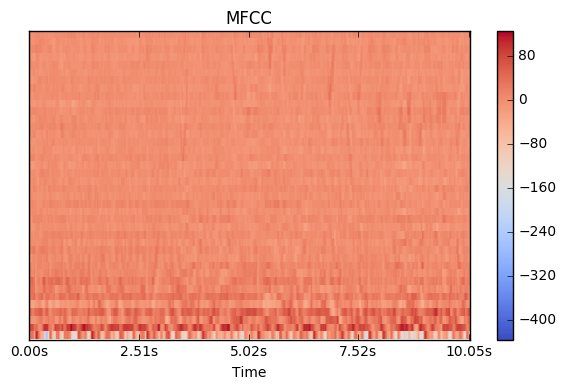

In [11]:
# Visualize the MFCCs for the randomly selected excerpt
%matplotlib inline
lr.display.specshow(dataSetTrain.mfcc.values[sample], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show

In [12]:
# Get the feature data for the test set
mfcc = []
y = []
sr = []
labels = []
labelNums = []

# Librosa loads and decodes the audio as a time series 'y', 
# represented as a one-dimensional NumPy floating point array. 
# The variable 'sr' contains the sampling rate of 'y', i.e., the number of samples per second of audio. 
# By default, all audio is mixed to mono and resampled to 22050 Hz at load time. 
dataSetTest = pd.DataFrame(columns=['Song','mfcc','y','sr','label','Genre'])

for f in mp3TestFiles:
    fObjTest = part2Tar.extract(f)
    
    _songTest = os.path.basename(f)
    _yTest, _srTest = lr.load(f)
    _mfccTest = lr.feature.mfcc(y=_yTest, sr=_srTest, n_mfcc=40)   
    _labelTest = testLabels.Genre[testLabels.Song==_songTest].values[0]
    _labelNumTest = categories[categories==_labelTest].index[0]

    mfcc.append(_mfccTest)
    y.append(_yTest)
    sr.append(_srTest)
    labels.append(_labelTest) 
    labelNums.append(_labelNumTest)
    
    _dfTest = pd.DataFrame([[_songTest, _mfccTest, _yTest, _srTest, _labelNumTest, 
                              _labelTest]], columns=['Song','mfcc','y','sr','label','Genre'])
    dataSetTest = dataSetTest.append(_dfTest, ignore_index=True)    

In [13]:
# Look at the last 5 rows of the Test data
dataSetTest.tail()

,Song,mfcc,y,sr,label,Genre
372,Mtest_95.mp3,"[[-193.071953303, -160.117309528, -154.5694180...","[0.000149817, 0.000713701, 0.000479169, -0.000...",22050.0,3.0,Folkcountry
373,Mtest_96.mp3,"[[-265.506612838, -243.210011945, -252.4282084...","[-0.000181097, -0.000158405, -0.0004983, -0.00...",22050.0,3.0,Folkcountry
374,Mtest_97.mp3,"[[-122.512487237, -98.1739429537, -91.17967868...","[0.000482491, 0.00132375, 0.000509062, 8.83424...",22050.0,3.0,Folkcountry
375,Mtest_98.mp3,"[[-69.5026470997, -37.9092624951, -42.13097072...","[0.00104039, -0.000700023, -0.00109616, -0.002...",22050.0,3.0,Folkcountry
376,Mtest_99.mp3,"[[-87.1110518642, -70.6288544074, -94.54177489...","[-0.00109002, -0.00217231, -0.00211794, -0.002...",22050.0,3.0,Folkcountry


In [16]:
import pickle
pickle.dump(dataSetTrain[0:1000], open('dataSetTrain2.7_1.pkl', 'wb'))
pickle.dump(dataSetTrain[1000:-1], open('dataSetTrain2.7_2.pkl', 'wb'))
pickle.dump(dataSetTest, open('dataSetTest2.7.pkl', 'wb'))

In [15]:
print(trainLabels.shape)

(1509, 2)
